खालील उदाहरण [TensorFlow च्या मूळ ट्यूटोरियलवरून](https://www.tensorflow.org/tutorials/generative/style_transfer) तसेच [या ब्लॉग पोस्टवरून](https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216) प्रेरित आहे. CNTK फ्रेमवर्क वापरून स्टाइल ट्रान्सफरचे आणखी एक चांगले उदाहरण [येथे](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_205_Artistic_Style_Transfer.ipynb) उपलब्ध आहे. [Artistic Style Transfer](https://arxiv.org/abs/1508.06576) या विषयावरील मूळ पेपर येथे आहे.

स्टाइल ट्रान्सफरमागील मुख्य कल्पना पुढीलप्रमाणे आहेत:

* पांढऱ्या आवाजापासून सुरुवात करून, आम्ही सध्याच्या प्रतिमेचे $x$ ऑप्टिमाइझ करण्याचा प्रयत्न करतो जेणेकरून काही लॉस फंक्शन कमी होईल.
* लॉस फंक्शन तीन घटकांपासून बनलेले आहे $\mathcal{L(x)} = \alpha\mathcal{L}_c(x,i) + \beta\mathcal{L}_s(x,s)+\gamma\mathcal{L}_t(x)$
   - $\mathcal{L}_c$ - कंटेंट लॉस - सध्याची प्रतिमा $x$ मूळ प्रतिमा $i$ च्या किती जवळ आहे हे दर्शवते
   - $\mathcal{L}_s$ - स्टाइल लॉस - सध्याची प्रतिमा $x$ स्टाइल प्रतिमा $s$ च्या किती जवळ आहे हे दर्शवते
   - $\mathcal{L}_t$ - टोटल व्हेरिएशन लॉस (आपल्या उदाहरणात आपण याचा विचार करणार नाही) - परिणामी प्रतिमा गुळगुळीत असल्याचे सुनिश्चित करते, म्हणजेच प्रतिमा $x$ च्या शेजारील पिक्सल्सचा सरासरी वर्ग त्रुटी दर्शवते
   
या लॉस फंक्शन्स हुशारीने डिझाइन करणे आवश्यक आहे, जेणेकरून उदाहरणार्थ स्टाइल लॉस प्रतिमांच्या शैली समान असल्याचे दर्शवते, प्रत्यक्ष सामग्री नव्हे. यासाठी, आम्ही प्रतिमेकडे पाहणाऱ्या CNN च्या काही खोल फीचर लेयर्सची तुलना करू.


चला काही प्रतिमा लोड करून सुरू करूया:


In [1]:
!mkdir -p images
!curl https://cdn.pixabay.com/photo/2016/05/18/00/27/franz-marc-1399594_960_720.jpg > images/style.jpg
!curl https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_tabby_and_white_kitten_n01.jpg/1280px-Golden_tabby_and_white_kitten_n01.jpg > images/image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210k  100  210k    0     0  2670k      0 --:--:-- --:--:-- --:--:-- 2670k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131k  100  131k    0     0   459k      0 --:--:-- --:--:-- --:--:--  459k


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
import IPython.display as display

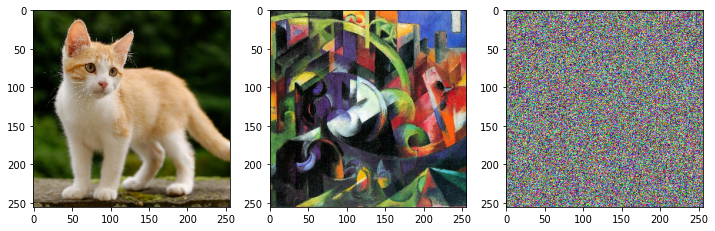

In [31]:
img_size = 256

def load_image(fn):
  x = cv2.imread(fn)
  return cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

img_style = load_image('images/style.jpg')
img_content = load_image('images/image.jpg')
img_content = img_content[:,200:200+857,:]
img_content = cv2.resize(img_content,(img_size,img_size))
img_style = img_style[:,200:200+671,:]
img_style = cv2.resize(img_style,(img_size,img_size))

img_result = np.random.uniform(size=(img_size,img_size,3))

matplotlib.rcParams['figure.figsize'] = (12, 12)
matplotlib.rcParams['axes.grid'] = False

fig,ax = plt.subplots(1,3)
ax[0].imshow(img_content)
ax[1].imshow(img_style)
ax[2].imshow((255*img_result).astype(int))
plt.show()

स्टाइल लॉस आणि कंटेंट लॉसची गणना करण्यासाठी, आपल्याला CNN द्वारे काढलेल्या फीचर स्पेसमध्ये काम करणे आवश्यक आहे. आपण वेगवेगळ्या CNN आर्किटेक्चरचा वापर करू शकतो, परंतु आपल्या प्रकरणात सुलभतेसाठी, आपण *ImageNet* वर प्री-ट्रेन केलेला VGG-19 निवडू.


In [32]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg.trainable = False

In [33]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

चला अशी एक फंक्शन परिभाषित करूया जी आपल्याला VGG नेटवर्कमधून मध्यम स्तरावरील वैशिष्ट्ये काढण्याची परवानगी देईल:


In [34]:
def layer_extractor(layers):
    outputs = [vgg.get_layer(x).output for x in layers]
    model = tf.keras.Model([vgg.input],outputs)
    return model 

## सामग्री गमावणे

**सामग्री गमावणे** हे दर्शवेल की आपली सध्याची प्रतिमा $x$ मूळ प्रतिमेच्या किती जवळ आहे. हे CNN मधील मध्यम वैशिष्ट्य स्तरांकडे पाहते आणि वर्ग त्रुटीची गणना करते. स्तर $l$ वरील सामग्री गमावणे खालीलप्रमाणे परिभाषित केले जाईल:
$$
\mathcal{L}_c = {1\over2}\sum_{i,j} (F_{ij}^{(l)}-P_{ij}^{(l)})^2
$$
जिथे $F^{(l)}$ आणि $P^{(l)}$ -- स्तर $l$ वरील वैशिष्ट्ये.


In [35]:
content_layers = ['block4_conv2'] 
content_extractor = layer_extractor(content_layers)

content_target = content_extractor(preprocess_input(tf.expand_dims(img_content,axis=0)))

def content_loss(img):
    z = content_extractor(preprocess_input(tf.expand_dims(255*img,axis=0))) 
    return 0.5*tf.reduce_sum((z-content_target)**2)

आता आपण शैली हस्तांतरणाचा मुख्य युक्ती - **ऑप्टिमायझेशन** लागू करू. आपण एका यादृच्छिक प्रतिमेसह सुरुवात करू आणि नंतर TensorFlow ऑप्टिमायझर वापरून ही प्रतिमा समाविष्ट सामग्री गमावणे कमी करण्यासाठी समायोजित करू.

**महत्त्वाचे**: आपल्या प्रकरणात, सर्व गणना GPU-सक्षम *TensorFlow* फ्रेमवर्क वापरून केली जातात, ज्यामुळे हा कोड GPU वर अधिक कार्यक्षमतेने चालतो.


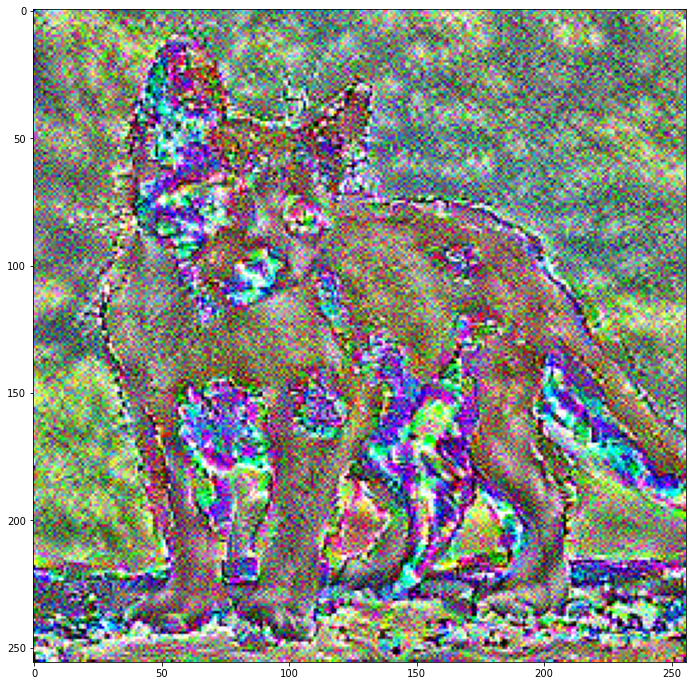

In [63]:
img = tf.Variable(img_result)
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-1)

clip = lambda x : tf.clip_by_value(x,clip_value_min=0,clip_value_max=1)

def optimize(img,loss_fn):
    with tf.GradientTape() as tape:
        loss = loss_fn(img)
    grad = tape.gradient(loss,img)
    opt.apply_gradients([(grad,img)])
    #img.assign(tf.clip_by_value(img,clip_value_min=0,clip_value_max=1))

def train(img,loss_fn,epochs=10,steps_per_epoch=100):
    for _ in range(epochs):
        display.clear_output(wait=True)
        plt.imshow((255*clip(img)).numpy().astype(int))
        plt.show()
        for _ in range(steps_per_epoch):
            optimize(img,loss_fn=loss_fn)

train(img,content_loss)

> **व्यायाम**: नेटवर्कमधील वेगवेगळ्या स्तरांवर प्रयोग करून बघा आणि काय होते ते पाहा. तुम्ही अनेक स्तरांसाठी एकत्रितपणे ऑप्टिमायझेशन करण्याचाही प्रयत्न करू शकता, परंतु त्यासाठी तुम्हाला `content_loss` कोड थोडासा बदलावा लागेल.

## शैली गमावणे

शैली गमावणे हे शैली हस्तांतरणामागील मुख्य कल्पना आहे. येथे आपण प्रत्यक्ष वैशिष्ट्यांची तुलना करत नाही, तर त्यांच्या ग्राम मॅट्रिक्सची तुलना करतो, ज्याला $$G=A\times A^T$$ असे परिभाषित केले जाते.

ग्राम मॅट्रिक्स हा सहसंबंध मॅट्रिक्ससारखाच असतो आणि तो दाखवतो की काही फिल्टर्स इतरांवर कसे अवलंबून असतात. शैली गमावणे हे वेगवेगळ्या स्तरांवरील गमावण्यांच्या बेरीजने मोजले जाते, जे सहसा भारित गुणांकांसह विचारात घेतले जातात.

शैली हस्तांतरणासाठी एकूण गमावण्याचे कार्य हे *content loss* आणि *style loss* यांची बेरीज असते.


In [64]:
def gram_matrix(x):
  result = tf.linalg.einsum('bijc,bijd->bcd', x, x)
  input_shape = tf.shape(x)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']

def style_extractor(img):
    return [gram_matrix(x) for x in layer_extractor(style_layers)(img)]

style_target = style_extractor(preprocess_input(tf.expand_dims(img_style,axis=0)))

def style_loss(img):
    z = style_extractor(preprocess_input(tf.expand_dims(255*img,axis=0)))
    loss = tf.add_n([tf.reduce_mean((x-target)**2) 
                           for x,target in zip(z,style_target)])
    return loss / len(style_layers)


## सर्व एकत्र करणे

आम्ही `total_loss` फंक्शन परिभाषित करू, जे एकत्रित नुकसानाची गणना करेल, आणि ऑप्टिमायझेशन चालवू:


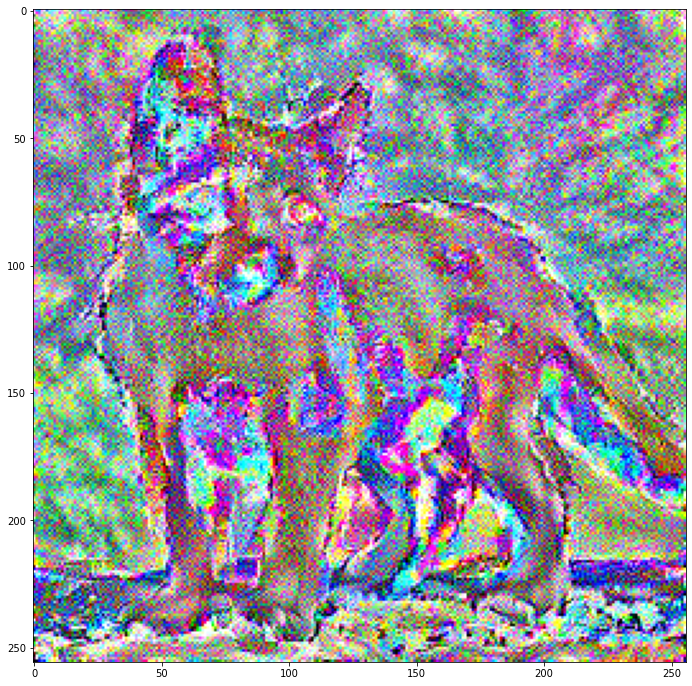

In [65]:
def total_loss(img):
    return 2*content_loss(img)+style_loss(img)

img.assign(img_result)

train(img,loss_fn=total_loss)

खालील कोड नुकसानाचे वास्तविक ऑप्टिमायझेशन करते. लक्षात ठेवा की GPU असतानाही ऑप्टिमायझेशनसाठी लक्षणीय वेळ लागतो. परिणाम सुधारण्यासाठी तुम्ही खालील सेल अनेक वेळा चालवू शकता.


## व्हेरिएशन लॉस जोडा

**व्हेरिएशन लॉस** आपल्याला प्रतिमा कमी गोंगाटयुक्त बनवण्यास मदत करते, शेजारील पिक्सेलमधील फरक कमी करून.

आपण मूळ कंटेंट प्रतिमेपासून ऑप्टिमायझेशन सुरू करू, ज्यामुळे प्रतिमेमध्ये अधिक कंटेंट तपशील टिकवून ठेवता येतील, आणि कंटेंट लॉस फंक्शन अधिक गुंतागुंतीचे होणार नाही. मात्र, आपण थोडासा गोंगाट जोडू.


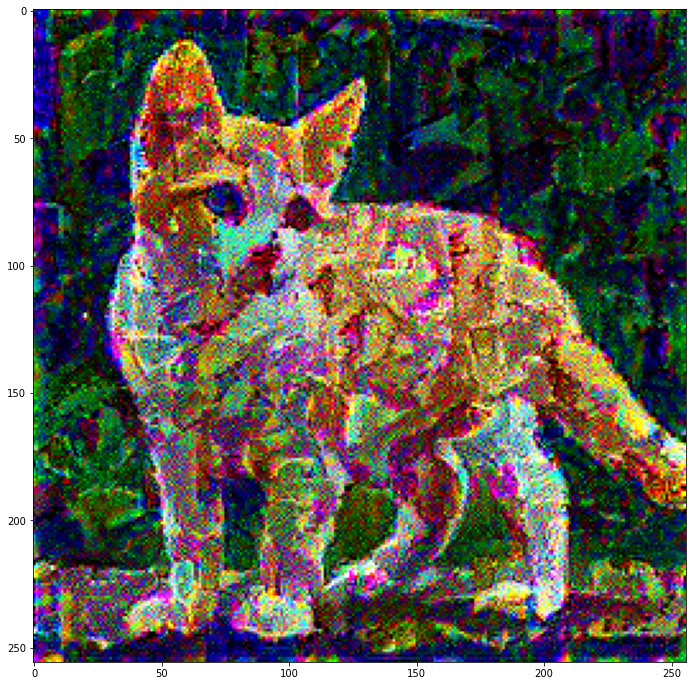

In [95]:
def variation_loss(img):
  img = tf.cast(img,tf.float32)
  x_var = img[ :, 1:, :] - img[ :, :-1, :]
  y_var = img[ 1:, :, :] - img[ :-1, :, :]
  return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))
  
def total_loss_var(img):
    return content_loss(img)+150*style_loss(img)+30*variation_loss(img)

img.assign(clip(np.random.normal(-0.3,0.3,size=img_content.shape)+img_content/255.0))

train(img,loss_fn=total_loss_var)

In [94]:
cv2.imwrite('result.jpg',(img.numpy()[:,:,::-1]*255))

(256, 256, 3)


True


---

**अस्वीकरण**:  
हा दस्तऐवज AI भाषांतर सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) वापरून भाषांतरित करण्यात आला आहे. आम्ही अचूकतेसाठी प्रयत्नशील असलो तरी, कृपया लक्षात घ्या की स्वयंचलित भाषांतरांमध्ये त्रुटी किंवा अचूकतेचा अभाव असू शकतो. मूळ भाषेतील मूळ दस्तऐवज हा अधिकृत स्रोत मानला जावा. महत्त्वाच्या माहितीसाठी, व्यावसायिक मानवी भाषांतराची शिफारस केली जाते. या भाषांतराचा वापर करून उद्भवणाऱ्या कोणत्याही गैरसमज किंवा चुकीच्या अर्थासाठी आम्ही जबाबदार राहणार नाही.
